# Transformer Model Training

In [1]:
import os
import sys
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
from sklearn.metrics import roc_curve, auc
from edm.jobs.transformer_job import TransformerJob

pd.set_option('display.max_columns', None)

In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
df_summary = pd.read_csv("/deep/group/ed-monitor/patient_data_v9/waveforms/15sec-500hz-1norm-10wpp/II/transformer-64-logits/embeddings_summary.csv")
df_summary.head(3)

In [4]:
logits = np.load("/deep/group/ed-monitor/patient_data_v9/waveforms/15sec-500hz-1norm-10wpp/II/transformer-64-logits/embeddings.dat.npy")
logits.shape

(10874, 24)

In [ ]:
df = pd.read_csv("/deep/group/ed-monitor/patient_data_v9/consolidated.filtered.csv")
print(df.shape)
df.head(2)

In [9]:
csn_to_index = {}
for i, row in df_summary.iterrows():
    csn_to_index[row["record_name"]] = i
print(len(csn_to_index))

10874


In [10]:
logits_0 = []
logits_1 = []

for i, row in tqdm(df.iterrows()):
    if row["outcome"] == 0:
        logits_0.append(logits[csn_to_index[row["CSN"]]])
    else:
        logits_1.append(logits[csn_to_index[row["CSN"]]])

logits_0 = np.array(logits_0)
logits_1 = np.array(logits_1)

print(f"0 = {logits_0.shape}")
print(f"1 = {logits_1.shape}")

10874it [00:01, 6005.24it/s]

0 = (9817, 24)
1 = (1057, 24)


In [11]:
rhythm_output = sorted(['270492004', '164889003', '164890007', '426627000', '713427006', 
                  '713426002', '445118002', '39732003', '164909002', '251146004', 
                  '698252002', '10370003', '284470004', '427172004', '164947007', 
                  '111975006', '164917005', '47665007', '427393009',
                  '426177001', '426783006', '427084000', '164934002',
                  '59931005'])

concept_to_desc = {
    "270492004": "First degree atrioventricular block",
    "164889003": "Atrial fibrillation",
    "426627000": "Bradycardia",
    "164890007": "Atrial flutter",
    "713427006": "Complete right bundle branch block",
    "713426002": "Incomplete right bundle branch block",
    "445118002": "Left anterior fascicular block",
    "39732003": "Left axis deviation",
    "164909002": "Left bundle branch block",
    "251146004": "Low QRS voltage",
    "698252002": "Non-specific intraventricular conduction delay",
    "10370003": "Pacing rhythm",
    "284470004": "Premature atrial contraction",
    "427172004": "Premature ventricular contractions",
    "164947007": "Prolonged PR interval",
    "111975006": "Prolonged QT interval",
    "164917005": "Q wave abnormal",
    "47665007": "Right axis deviation",
    "427393009": "Sinus arrhythmia",
    "426177001": "Sinus bradycardia",
    "426783006": "Sinus rhythm",
    "427084000": "Sinus tachycardia",
    "164934002": "T wave abnormal",
    "59931005": "T wave inversion",
    "59118001": "Right bundle branch block (disorder)",
    "63593006": "Supraventricular premature beats",
    "17338001": "Ventricular premature beats"
}

for i in range(24):
    rhythm_output[i] = concept_to_desc[rhythm_output[i]]

for i in range(24):
    print(rhythm_output[i])

Pacing rhythm
Prolonged QT interval
Atrial fibrillation
Atrial flutter
Left bundle branch block
Q wave abnormal
T wave abnormal
Prolonged PR interval
Low QRS voltage
First degree atrioventricular block
Premature atrial contraction
Left axis deviation
Sinus bradycardia
Bradycardia
Sinus rhythm
Sinus tachycardia
Premature ventricular contractions
Sinus arrhythmia
Left anterior fascicular block
Right axis deviation
T wave inversion
Non-specific intraventricular conduction delay
Incomplete right bundle branch block
Complete right bundle branch block


In [37]:
for i in range(len(rhythm_output)):
    print(f"{rhythm_output[i]}")
    rel = stats.ttest_ind(logits_0[:, i], logits_1[:, i])
    print(f"> Control:           {np.percentile(logits_0[:, i], [50])} [{np.percentile(logits_0[:, i], [25])}, {np.percentile(logits_0[:, i], [75])}]")
    print(f"> Myocardial Injury: {np.percentile(logits_1[:, i], [50])} [{np.percentile(logits_1[:, i], [25])}, {np.percentile(logits_1[:, i], [75])}]")
    print(f"> p-value:           {rel.pvalue}")

Pacing rhythm
> Control:           [5.35058405e-07] [[1.16803761e-07], [1.55036446e-06]]
> Myocardial Injury: [6.75822605e-07] [[1.08957622e-07], [2.84914995e-06]]
> p-value:           0.013927032349797074
Prolonged QT interval
> Control:           [1.88597114e-05] [[8.54739756e-06], [5.55009392e-05]]
> Myocardial Injury: [4.46307822e-05] [[1.73950139e-05], [0.00011835]]
> p-value:           1.335045094712444e-10
Atrial fibrillation
> Control:           [0.00109065] [[0.00042788], [0.00355343]]
> Myocardial Injury: [0.00358955] [[0.00117489], [0.03043908]]
> p-value:           2.268096996504513e-13
Atrial flutter
> Control:           [1.28355632e-05] [[1.2418933e-06], [0.00010161]]
> Myocardial Injury: [0.00011642] [[1.73158824e-05], [0.00051969]]
> p-value:           1.0648701773639134e-34
Left bundle branch block
> Control:           [0.00153651] [[0.00072993], [0.00495236]]
> Myocardial Injury: [0.00403013] [[0.00124165], [0.02431145]]
> p-value:           9.397878461497374e-26
Q wa

In [12]:
def format_num(n):
    val = '{:.20f}'.format(n)
    new_val = ""
    in_digits = False
    digits = 3
    for v in val:
        if digits == 0:
            break
        if (v != "0" and v != ".") or in_digits:
            digits -= 1
            new_val += v
            in_digits = True
        else:
            new_val += v
    return new_val
#     if n < 0.0001:
#         return '{:0.2e}'.format(n)
#     else:
#         if '{:0.3f}'.format(n) == "0.000":
#             return "0"
#         else:
#             return '{:0.2f}'.format(n)

In [13]:
def format_pval(n):
    if n < 0.001:
        return "< 0.001"
    else:
        return '{:0.3f}'.format(n)

In [26]:
for i in range(len(rhythm_output)):
    rel = stats.ttest_ind(logits_0[:, i], logits_1[:, i], equal_var=False)
    l0_25 = np.percentile(logits_0[:, i], [25])[0] * 100
    l0_50 = np.percentile(logits_0[:, i], [50])[0] * 100
    l0_75 = np.percentile(logits_0[:, i], [75])[0] * 100
    l1_25 = np.percentile(logits_1[:, i], [25])[0] * 100
    l1_50 = np.percentile(logits_1[:, i], [50])[0] * 100
    l1_75 = np.percentile(logits_1[:, i], [75])[0] * 100
    ratio = round(np.percentile(logits_1[:, i], [50])[0] / np.percentile(logits_0[:, i], [50])[0], 2)
    mean_ratio = round(np.mean(logits_1[:, i]) / np.mean(logits_0[:, i]), 2)
    print(f"{rhythm_output[i]}\t{ratio}\t{mean_ratio}\t{format_num(l1_50)} [{format_num(l1_25)}, {format_num(l1_75)}]\t{format_num(l0_50)} [{format_num(l0_25)}, {format_num(l0_75)}]\t{format_pval(rel.pvalue)}")



Pacing rhythm	1.26	2.8299999237060547	0.0000675 [0.0000108, 0.000284]	0.0000535 [0.0000116, 0.000155]	0.103
Prolonged QT interval	2.37	2.359999895095825	0.00446 [0.00173, 0.0118]	0.00188 [0.000854, 0.00555]	< 0.001
Atrial fibrillation	3.29	1.8700000047683716	0.358 [0.117, 3.0]	0.109 [0.0427, 0.355]	< 0.001
Atrial flutter	9.07	3.0199999809265137	0.0116 [0.00173, 0.0519]	0.00128 [0.000124, 0.0101]	< 0.001
Left bundle branch block	2.62	2.5899999141693115	0.403 [0.124, 2.4]	0.153 [0.0729, 0.495]	< 0.001
Q wave abnormal	1.38	1.9199999570846558	0.00507 [0.00267, 0.00997]	0.00368 [0.00221, 0.00618]	< 0.001
T wave abnormal	2.95	2.25	0.0437 [0.0162, 0.0966]	0.0148 [0.00833, 0.0433]	< 0.001
Prolonged PR interval	0.36	1.2200000286102295	0.000000247 [0.0000000266, 0.00000308]	0.000000698 [0.0000000872, 0.00000521]	0.585
Low QRS voltage	1.27	1.6399999856948853	0.0131 [0.00532, 0.0290]	0.0103 [0.00547, 0.0189]	< 0.001
First degree atrioventricular block	1.97	1.1699999570846558	0.171 [0.0630, 0.607]	

```
library(mratios)

logits_0 <- read.csv("/Users/tom/Documents/Stanford/Myocardial Injury/logits/logits_0.csv")
logits_1 <- read.csv("/Users/tom/Documents/Stanford/Myocardial Injury/logits/logits_1.csv")

for(col in colnames(logits_0)) {
    print(col)
    print(ttestratio(logits_1[[col]], logits_0[[col]]))
}
```

```
[1] "Pacing.rhythm"
t = 1.631, df = 1136.6, p-value = 0.1032
1.494189e-05 5.285802e-06 2.826797e+00 
[1] "Prolonged.QT.interval"
t = 3.4931, df = 1100.5, p-value = 0.0004964
2.146039e-04 9.083626e-05 2.362536e+00 
[1] "Atrial.fibrillation"
t = 6.111, df = 1204.1, p-value = 1.335e-09
0.10552930 0.05652415 1.86697712 
[1] "Atrial.flutter"
t = 6.1168, df = 1088.6, p-value = 1.33e-09
0.0007416118 0.0002456973 3.0183958922 
[1] "Left.bundle.branch.block"
t = 7.3501, df = 1149.1, p-value = 3.75e-13
0.05189044 0.02001484 2.59259913 
[1] "Q.wave.abnormal"
t = 4.5562, df = 1089.1, p-value = 5.797e-06
1.244553e-04 6.479694e-05 1.920696e+00 
[1] "T.wave.abnormal"
t = 6.0077, df = 1100.2, p-value = 2.555e-09
0.0011006109 0.0004882202 2.2543328529 
[1] "Prolonged.PR.interval"
t = 0.54666, df = 1257.7, p-value = 0.5847
1.313850e-06 1.072907e-06 1.224571e+00 
[1] "Low.QRS.voltage"
t = 5.8338, df = 1115, p-value = 7.095e-09
0.0003035827 0.0001848751 1.6420962553 
[1] "First.degree.atrioventricular.block"
t = 1.2757, df = 1271.8, p-value = 0.2023
0.04369193 0.03749455 1.16528769 
[1] "Premature.atrial.contraction"
t = 1.9351, df = 1268.2, p-value = 0.05321
0.04617392 0.04122888 1.11994122 
[1] "Left.axis.deviation"
t = 6.4383, df = 1212.3, p-value = 1.737e-10
0.0008437723 0.0003716659 2.2702441203 
[1] "Sinus.bradycardia"
t = -0.67987, df = 1276.4, p-value = 0.4967
0.002580841 0.002873173 0.898254649 
[1] "Bradycardia"
t = -1.9708, df = 1380.3, p-value = 0.04894
0.01285964 0.01627381 0.79020432 
[1] "Sinus.rhythm"
t = -21.779, df = 1673.7, p-value < 2.2e-16
0.05654736 0.15857274 0.35660200 
[1] "Sinus.tachycardia"
t = 6.0618, df = 1132.6, p-value = 1.831e-09
0.03577990 0.01480625 2.41654030 
[1] "Premature.ventricular.contractions"
t = 9.7905, df = 1158.2, p-value < 2.2e-16
0.012372901 0.007221136 1.713428533 
[1] "Sinus.arrhythmia"
t = -10.198, df = 2083.1, p-value < 2.2e-16
0.0002656899 0.0005108631 0.5200804212 
[1] "Left.anterior.fascicular.block"
t = 3.5694, df = 1386.4, p-value = 0.00037
6.452755e-06 3.164017e-06 2.039419e+00 
[1] "Right.axis.deviation"
t = 9.1515, df = 1110.2, p-value < 2.2e-16
1.820776e-04 8.189028e-05 2.223433e+00 
[1] "T.wave.inversion"
t = 8.6701, df = 1110.7, p-value < 2.2e-16
0.0009706346 0.0005011168 1.9369430220 
[1] "Non.specific.intraventricular.conduction.delay"
t = 9.153, df = 1121.6, p-value < 2.2e-16
0.0003621331 0.0001964768 1.8431341693 
[1] "Incomplete.right.bundle.branch.block"
t = 8.2826, df = 1186.4, p-value = 3.22e-16
0.003239823 0.002309575 1.402778617 
[1] "Complete.right.bundle.branch.block"
t = 5.5542, df = 1224.3, p-value = 3.418e-08
0.1564134 0.1099697 1.4223316 
```

```
Atrial flutter	3.02 [2.35-3.73]	< 0.001
Pacing rhythm	2.83 [0.65-6.20]	0.103
Left bundle branch block	2.59 [2.14-3.09]	< 0.001
Sinus tachycardia	2.42 [1.94-2.93]	< 0.001
Prolonged QT interval	2.36 [1.59-3.20]	< 0.001
Left axis deviation	2.27 [1.85-2.73]	< 0.001
T wave abnormal	2.25 [1.83-2.69]	< 0.001
Right axis deviation	2.22 [1.95-2.50]	< 0.001
Left anterior fascicular block	2.04 [1.43-2.83]	< 0.001
T wave inversion	1.94 [1.72-2.16]	< 0.001
Q wave abnormal	1.92 [1.52-2.33]	< 0.001
Atrial fibrillation	1.87 [1.58-2.18]	< 0.001
Non-specific intraventricular conduction delay	1.84 [1.66-2.03]	< 0.001
Premature ventricular contractions	1.71 [1.57-1.86]	< 0.001
Low QRS voltage	1.64 [1.42-1.87]	< 0.001
Complete right bundle branch block	1.42 [1.27-1.58]	< 0.001
Incomplete right bundle branch block	1.40 [1.31-1.50]	< 0.001
Prolonged PR interval	1.22 [0.45-2.14]	0.585
First degree atrioventricular block	1.17 [0.91-1.43]	0.202
Premature atrial contraction	1.12 [1.00-1.24]	0.053
Sinus bradycardia	0.90 [0.61-1.20]	0.497
Bradycardia	0.79 [0.59-1.00]	0.049
Sinus arrhythmia	0.52 [0.44-0.60]	< 0.001
Sinus rhythm	0.36 [0.30-0.41]	< 0.001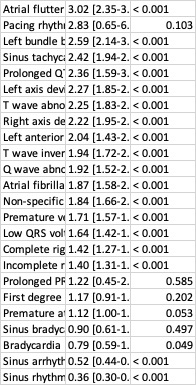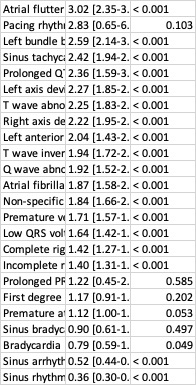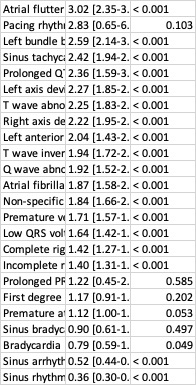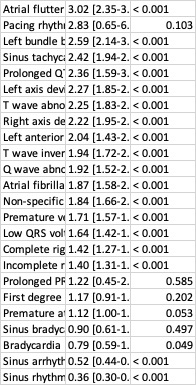
```

In [18]:
logits_0.shape

(9817, 24)

In [19]:
logits_1.shape

(1057, 24)

In [22]:
df_0 = pd.DataFrame(data=logits_0, columns=[rhythm_output])
print(df_0.shape)
df_0.head(2)

(9817, 24)


,Pacing rhythm,Prolonged QT interval,Atrial fibrillation,Atrial flutter,Left bundle branch block,Q wave abnormal,T wave abnormal,Prolonged PR interval,Low QRS voltage,First degree atrioventricular block,Premature atrial contraction,Left axis deviation,Sinus bradycardia,Bradycardia,Sinus rhythm,Sinus tachycardia,Premature ventricular contractions,Sinus arrhythmia,Left anterior fascicular block,Right axis deviation,T wave inversion,Non-specific intraventricular conduction delay,Incomplete right bundle branch block,Complete right bundle branch block
0,6.227906e-08,0.000094,0.000765,0.000014,0.000655,0.000050,0.000398,4.686931e-09,0.000266,0.000893,0.016586,0.000022,0.000020,0.000182,0.072685,0.000415,0.004961,0.000065,5.113854e-09,0.000022,0.000514,0.000104,0.001051,0.016587
1,3.089370e-06,0.000069,0.003745,0.000072,0.022125,0.000064,0.000438,2.304042e-08,0.000187,0.001783,0.041136,0.000539,0.000069,0.000952,0.019906,0.001736,0.011372,0.000115,2.611734e-06,0.000134,0.000610,0.000287,0.004377,0.101330


In [23]:
df_1 = pd.DataFrame(data=logits_1, columns=[rhythm_output])
print(df_1.shape)
df_1.head(2)

(1057, 24)


,Pacing rhythm,Prolonged QT interval,Atrial fibrillation,Atrial flutter,Left bundle branch block,Q wave abnormal,T wave abnormal,Prolonged PR interval,Low QRS voltage,First degree atrioventricular block,Premature atrial contraction,Left axis deviation,Sinus bradycardia,Bradycardia,Sinus rhythm,Sinus tachycardia,Premature ventricular contractions,Sinus arrhythmia,Left anterior fascicular block,Right axis deviation,T wave inversion,Non-specific intraventricular conduction delay,Incomplete right bundle branch block,Complete right bundle branch block
0,1.015235e-06,0.000018,0.005921,0.000013,0.027721,0.000075,0.000325,8.466184e-11,0.000009,0.000548,0.020677,0.000655,0.000127,0.000917,0.001699,0.000143,0.001719,0.000034,6.578590e-06,0.000085,0.000456,0.000173,0.010422,0.860378
1,9.900012e-07,0.000155,0.929965,0.002326,0.000914,0.000065,0.001672,6.634366e-12,0.000391,0.000212,0.003660,0.000043,0.000001,0.000002,0.000086,0.000121,0.004861,0.000005,2.389249e-08,0.000268,0.000937,0.000297,0.001295,0.009967


In [24]:
df_0.to_csv("/deep/group/ed-monitor/patient_data_v9/logits/logits_0.csv", index=False)
df_1.to_csv("/deep/group/ed-monitor/patient_data_v9/logits/logits_1.csv", index=False)